# Directivity and S-paramters computation of rectangular patch antenna 

A rectangular patch antenna is a type of microstrip antenna consisting of a rectangular conductive patch placed on a dielectric substrate with a ground plane on the opposite side. These antennas are widely used in wireless communication applications due to their simple design, ease of fabrication, and low profile.

In this notebook, we will demonstrate how to use Tidy3D to simulate a rectangular patch antenna [1] and obtain key performance metrics such as S-parameters, directivity, axial ratio, and polarized far-field components.

In [1]:
# Tidy3d import 
import tidy3d as td
from tidy3d.web import run
from tidy3d_backend.run import run_sim

# Tidy3d plugin import
import tidy3d.plugins.smatrix as smatrix

# External modules needed for this notebook
import numpy as np
import matplotlib.pyplot as plt
td.config.logging_level = "ERROR"

We set the frequency range to 20GHz, and the substrate takes a relative permittivity 2.2

In [2]:
# Scaling used for millimeters
mm = 1e3 

# Frequency range
freq_start = 0.5e9
freq_stop = 20e9

freq0 = (freq_start + freq_stop) / 2
freq_target = [7.5e9, 10e9] # targeted frequencies for directivity and axial ratio
fwidth = freq_stop - freq_start
wavelength0 = td.C_0 / freq0

freqs = np.linspace(freq_start, freq_stop, 200)
run_time = 400 / fwidth

# Material present
air = td.Medium()
epsr = 2.2
sub_medium = td.Medium(permittivity=epsr)
PEC = td.PEC2D


The structures are made of four components, substrate, ground plane, radiation patch and feed line. The substrate takes the designed parameters, and metal geometries are modeled as 2D PECs.

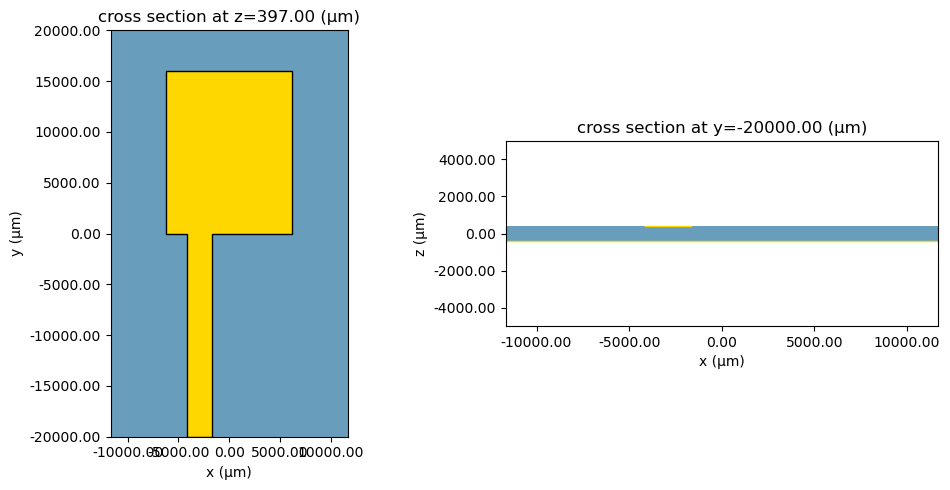

In [3]:
# Define simulation size
size_sim = [80*mm, 80*mm, 50*mm]

# Patch antenna parameters from [1]

# Substrate parameters
sub_x = 23.34 * mm 
sub_y = 40 * mm 
sub_z = 0.794 * mm 

# Patch parameters
patch_x = 12.45 * mm 
patch_y = 16 * mm

# Feedline parameters
feed_x = 2.46 * mm 
feed_y = 20 * mm 
feed_offset = 2.09 * mm

# Define substrate structure
substrate = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[sub_x, sub_y, sub_z]),
    medium=sub_medium,
)

# Define ground plane structure and assign the material by PEC
ground_plane = td.Structure(
    geometry=td.Box.from_bounds([-sub_x / 2, -sub_y / 2, -sub_z / 2], [sub_x / 2, sub_y / 2, -sub_z / 2]),
    medium=PEC,
)

# Define patch geometry
patch_geometry = td.Box.from_bounds(
    [-patch_x / 2, -sub_y / 2 + feed_y, sub_z / 2],
    [patch_x / 2, -sub_y / 2 + feed_y + patch_y, sub_z / 2] \
)

# Define feedline geometry
feedline_geometry = td.Box.from_bounds(
    [-patch_x / 2 + feed_offset, -sub_y / 2, sub_z / 2],
    [-patch_x / 2 + feed_offset + feed_x, -sub_y / 2 + feed_y, sub_z / 2]
)

# Radiation geometry is unionized by the patch geometry and feedline
radiating_geometry = td.ClipOperation(
    operation='union',
    geometry_a=patch_geometry,
    geometry_b=feedline_geometry
)

# Define radiating structure and assign conductive patch by PEC2D
radiating_structure = td.Structure(
    geometry=radiating_geometry,
    medium=PEC,
)

# List of structures for the simulation, put substrate first as PEC structures overrides substrate at materail interfaces
structures_list = [substrate, ground_plane, radiating_structure]

# Create geometry profile for the scene
geometry_profile = td.Scene(
    structures=structures_list,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Examine the structure in the x-y plane
geometry_profile.plot(z=sub_z / 2, ax=axs[0])
axs[0].set_xlim(-sub_x / 2, sub_x / 2)
axs[0].set_ylim(-sub_y / 2, sub_y / 2)

# Examine the structure in the x-z plane
geometry_profile.plot(y=-sub_y / 2, ax=axs[1])
axs[1].set_xlim(-sub_x / 2, sub_x / 2)
axs[1].set_ylim(-5 * mm, 5 * mm)

plt.show()

In [4]:
# Field monitor to view the electromagnetic fields in the patch plane
field_monitor = td.FieldMonitor(
    center=(0, 0, sub_z / 2),
    size=(td.inf, td.inf, 0),
    freqs=freq_target,  
    name="field",
)

# Radial distance to project fields
r = 50 * wavelength0   

# Define theta and phi angles for DirectitiviyMonitor
theta = np.linspace(-np.pi, np.pi, 200)
phi = np.linspace(0, np.pi, 100)

# Define the DirectivityMonitor to obtain directivity, axial ratio and polarized fields.
monitor_dir = td.DirectivityMonitor(
    center=[0, 0, 0],
    size=(30 * mm, 45 * mm, 4 * mm),
    freqs=freq_target,   
    name="radiation",
    phi=list(phi),
    theta=list(theta),
    far_field_approx=True,
)

# Truncate the computational domain by PMLs
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)

# Create the simulation object
sim = td.Simulation(
    center=[0, 0, 0],
    size=size_sim,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
        wavelength=td.C_0 / freq_stop,   
    ),
    structures=structures_list,  
    sources=[],  
    monitors=[monitor_dir, field_monitor],
    run_time=run_time,   
    boundary_spec=boundary_spec,
    shutoff=1e-5,
    subpixel=True,
)

In [5]:
# Define the port impedance
port_impedance = 50

# Define the lumped port for the simulation
port = smatrix.LumpedPort(
    center=[-patch_x / 2 + feed_offset + feed_x / 2, -sub_y / 2+2*mm, 0],
    size=[feed_x, 0, sub_z],
    voltage_axis=2,
    name="lumped_port",
    impedance=port_impedance,
)

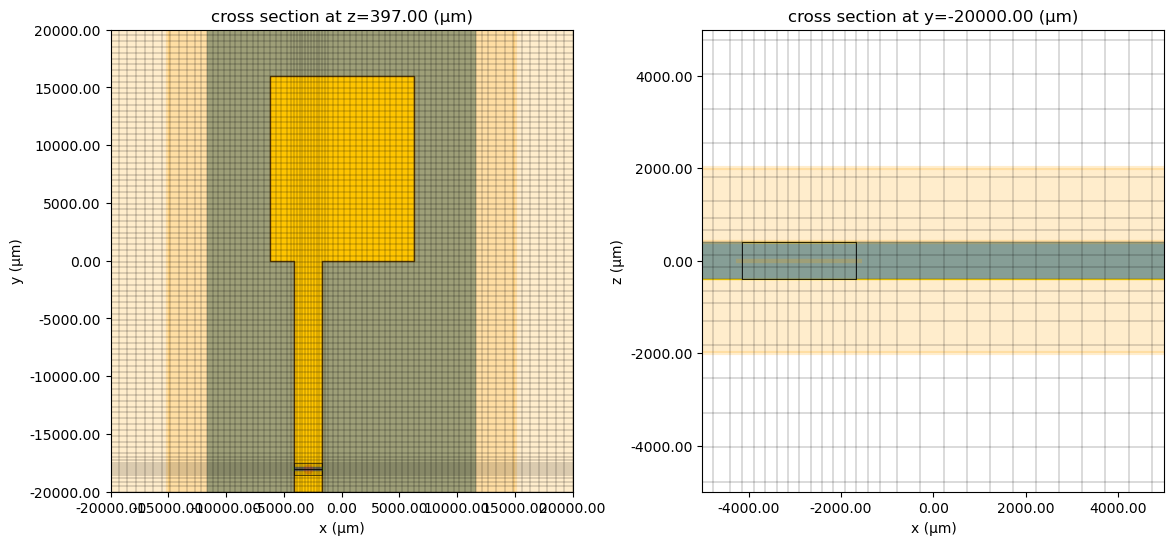

In [6]:
# Define the Terminal Component Modeler
modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[port],
    freqs=freqs,
    verbose=True,
)

# Extract the first simulation port from the modeler
sim_port1 = list(modeler.sim_dict.values())[0]

# Define zoom levels for the plots
zoom1 = 20 * mm
zoomv = 20 * mm
zoom2 = 5 * mm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Examine the structure in the x-y plane
sim_port1.plot(z=sub_z / 2, ax=ax1, hlim=[-zoom1, zoom1], vlim=[-zoomv, zoomv], monitor_alpha=0.2)
sim_port1.plot_grid(z=sub_z / 2, ax=ax1, hlim=[-zoom1, zoom1], vlim=[-zoomv, zoomv])

# Examine the structure in the x-z plane
sim_port1.plot(y=-sub_y / 2+2*mm, ax=ax2, hlim=[-zoom2, zoom2], vlim=[-zoom2, zoom2], monitor_alpha=0.2)
sim_port1.plot_grid(y=-sub_y / 2, ax=ax2, hlim=[-zoom2, zoom2], vlim=[-zoom2, zoom2])

# Show the plots
plt.show()

In [ ]:
batch_data = {
        task_name: run_sim(simulation) for task_name, simulation in modeler.sim_dict.items()
}

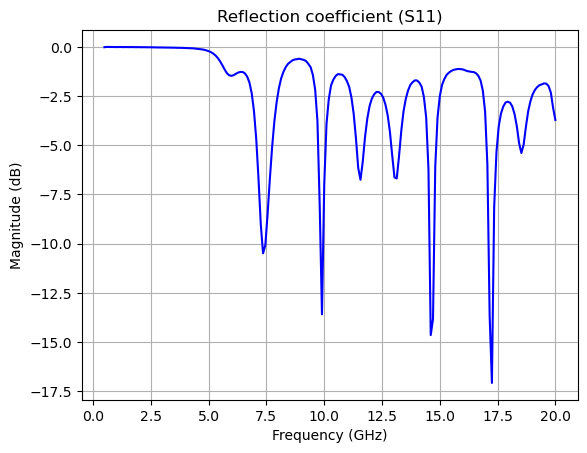

In [8]:
s_matrix = modeler._internal_construct_smatrix(batch_data)

plt.plot(s_matrix.f / 1e9, 20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten())),'-b');

plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dB)')
plt.title('Reflection coefficient (S11)')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Electric field distribution at 10 GHz')

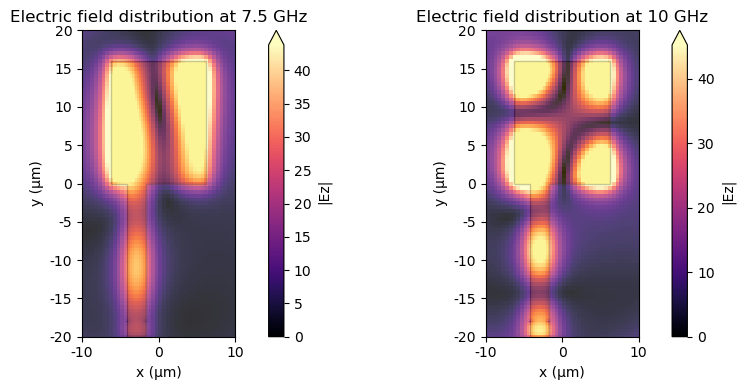

In [9]:
import matplotlib.ticker as ticker

formatter = ticker.FuncFormatter(lambda y, _: "{:g}".format((1e-3) * y))
sim_data = batch_data["smatrix_lumped_port"]


f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))
sim_data.plot_field(field_monitor_name="field", field_name="Ez", val="abs", f=freq_target[0], ax=ax1)
# Update plot labels
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

ax1.set_xlim([-10*mm, 10*mm])
ax1.set_ylim([-20*mm, 20*mm])
ax1.set_title("Electric field distribution at 7.5 GHz")

sim_data.plot_field(field_monitor_name="field", field_name="Ez", val="abs", f=freq_target[1], ax=ax2)
ax2.xaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

ax2.set_xlim([-10*mm, 10*mm])
ax2.set_ylim([-20*mm, 20*mm])
ax2.set_title("Electric field distribution at 10 GHz")


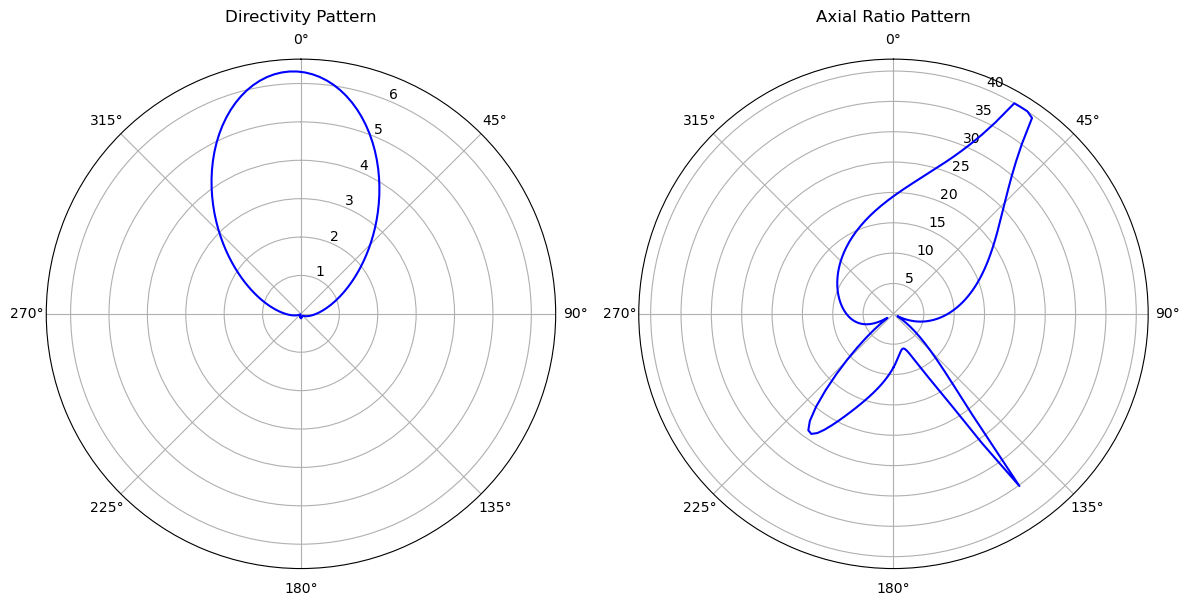

In [10]:
def log_value(values):
    return 20 * np.log10(values) 

# Extract directivity
D_directivity = sim_data["radiation"].directivity.sel(f=freq_target[0], phi=0, method="nearest")
D_directivity = np.squeeze(D_directivity)

# Extract axial ratio
AxialRatio = sim_data["radiation"].axial_ratio.sel(f=freq_target[0], phi=0, method="nearest")
AxialRatio = np.squeeze(AxialRatio)

# Create subplots for side-by-side polar plots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(12, 6), tight_layout=True)

# Plot directivity
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)
ax1.plot(theta, D_directivity, '-b', label="Tidy3D")
ax1.set_title("Directivity Pattern", va='bottom')

# Plot axial ratio
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
ax2.plot(theta, log_value(AxialRatio), '-b', label="Tidy3D")
ax2.set_title("Axial Ratio Pattern", va='bottom')

plt.show()

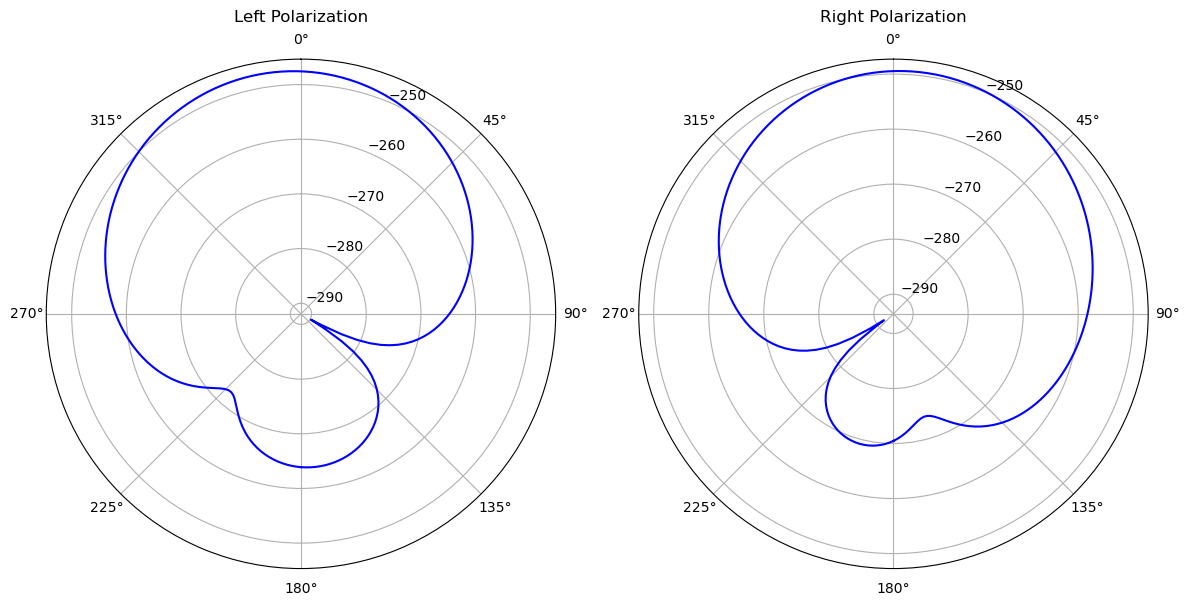

In [11]:
# Extract left polarization
left_polarization = sim_data["radiation"].left_polarization.sel(f=freq_target[0], phi=0, method="nearest").abs
left_polarization = np.squeeze(left_polarization)

# Extract right polarization
right_polarization = sim_data["radiation"].right_polarization.sel(f=freq_target[0], phi=0, method="nearest").abs
right_polarization = np.squeeze(right_polarization)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(12, 6), tight_layout=True)

# Plot left polarization
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)
ax1.plot(theta, log_value(left_polarization), '-b', label="Tidy3D")
ax1.set_title("Left Polarization", va='bottom')

# Plot right polarization
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
ax2.plot(theta, log_value(right_polarization), '-b', label="Tidy3D")
ax2.set_title("Right Polarization", va='bottom')

plt.show()